# Nitrogen and Light uptake relationship

## Imports

In [1]:
from cobra.io import read_sbml_model
from cobra import flux_analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reading the Models

In [2]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
Rubisco_carboxylase = c3_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p")
Rubisco_oxygenase = c3_model.reactions.get_by_id("RXN_961_p")
const = c3_model.problem.Constraint(3 * Rubisco_oxygenase.flux_expression - Rubisco_carboxylase.flux_expression , lb = 0, ub = 0)
c3_model.add_cons_vars(const)


#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

c3_maintenance(c3_model)

In [3]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[B]_Maize_biomass_tx'


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


## Performing pFBA

In [4]:
"""
Functions to perform the simulation:
For every given light uptake, we want to extract the nitrogen uptake flux valueas
"""



def c3_simulation(light, N, c3_model):
    with c3_model:
        c3_model.reactions.Photon_tx.lower_bound = 0
        c3_model.reactions.Photon_tx.upper_bound = light
        #Bounds for Nitrogen
        c3_model.reactions.Nitrate_tx.lower_bound = 0
        c3_model.reactions.Nitrate_tx.upper_bound = N
        #pFBA
        solution = flux_analysis.pfba(c3_model)
        solution_frame=solution.to_frame()
        nitrogen_uptake = solution_frame.loc["Nitrate_tx"]["fluxes"]
        return nitrogen_uptake

def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        m_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        bs_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        solution_frame=solution.to_frame()
        nitrogen_uptake = solution_frame.loc["[B]_Nitrate_tx"]["fluxes"] + solution_frame.loc["[M]_Nitrate_tx"]["fluxes"]
        return nitrogen_uptake

### Obtaining the lists with the light and nitrogen uptake flux values

In [5]:
"""
The chosen light uptake constrain range was from 50 to 1650 in 50 increments.
Nitrogen uptake was left unconstrained.
"""
L_up = []
N_C3_up = []
N_C4_up = []


for light in range(50, 1650, 50):
    L_up.append(light)
    N_C3_up.append(c3_simulation(light, 9999, c3_model))
    N_C4_up.append(c4_simulation(light, 9999, c4_model))

print(L_up)
print(N_C3_up)
print(N_C4_up)


[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600]
[0.5030322278816073, 1.0650421459213952, 1.6270520639613313, 2.189061982001202, 2.751071900041086, 3.3130818180809665, 3.8750917361208552, 4.437101654160714, 4.99911157220059, 5.561121490240462, 6.123131408280335, 6.685141326320201, 7.2471512443600705, 7.809161162400056, 8.37117108043966, 8.93318099847989, 9.49519091651982, 10.057200834559419, 10.619210752599598, 11.18122067063916, 11.743230588679353, 12.305240506719116, 12.867250424759403, 13.429260342799203, 13.991270260839023, 14.55328017887853, 15.115290096918418, 15.677300014958231, 16.239309932998097, 16.801319851038055, 17.363329769077946, 17.925339687117816]
[0.2298261431727415, 0.51826412018872, 0.8067020972046887, 1.0951400742205772, 1.3835780512366291, 1.672016028252505, 1.9604540052686814, 2.248891982284537, 2.5373299593003185, 2.825767936316318, 3.11420

## Results Scatterplot

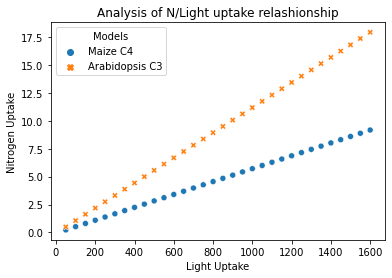

In [6]:
df_c3 = pd.DataFrame(list(zip(L_up, N_C3_up)), columns=["Light", "N"])
df_c4 = pd.DataFrame(list(zip(L_up, N_C4_up)), columns=["Light","N"])

concatenated = pd.concat([df_c4.assign(Models ='Maize C4'), df_c3.assign(Models ='Arabidopsis C3')])

sns.scatterplot(x='Light', y='N', data=concatenated, hue="Models", style='Models')
plt.title("Analysis of N/Light uptake relashionship")
plt.xlabel('Light Uptake')
plt.ylabel('Nitrogen Uptake')
#plt.savefig('nitrogen_relation.jpeg', format='jpeg', bbox_inches = 'tight')
plt.show()

From analysis of this results, we can conclude that light and nitrogen uptake have a linear relationship in both the C3 and C4 models. Furthermore, we observe a steeper curve in the C3 relationship than in the C4 model. This can be explained with the biomass composition values. The Arabidopsis biomass has a higher amount of aminoacids than the Maize Biomass, and, subsequently, higher nitrogen requirements for the same light inputs than the Maize biomass.